## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '60m'

perc_inc = 0.01 # 2 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'IYW' # IDEX penny stock, IYW iShares Tech ETF stock

perc_train = 0.6 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = '2y' # time span of data e.g. 1y or 10y, 2y for 60m, 10y for 1d
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-06-18 09:30:00-04:00,184.272507,185.220001,184.009995,185.199997,185.199997,0
2018-06-18 10:30:00-04:00,185.470200,186.350006,185.470200,186.070007,186.070007,10589
2018-06-18 11:30:00-04:00,186.119995,186.210007,185.830002,185.830002,185.830002,12388
2018-06-18 12:30:00-04:00,185.869904,186.229996,185.779999,186.229996,186.229996,14237
2018-06-18 13:30:00-04:00,186.199997,186.429993,186.159500,186.429993,186.429993,9214


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Datetime,,,,,,,
2018-06-18 09:30:00-04:00,184.272507,185.220001,184.009995,185.199997,185.199997,0,-0.005033
2018-06-18 10:30:00-04:00,185.470200,186.350006,185.470200,186.070007,186.070007,10589,-0.003234
2018-06-18 11:30:00-04:00,186.119995,186.210007,185.830002,185.830002,185.830002,12388,0.001558
2018-06-18 12:30:00-04:00,185.869904,186.229996,185.779999,186.229996,186.229996,14237,-0.001937
2018-06-18 13:30:00-04:00,186.199997,186.429993,186.159500,186.429993,186.429993,9214,-0.001235


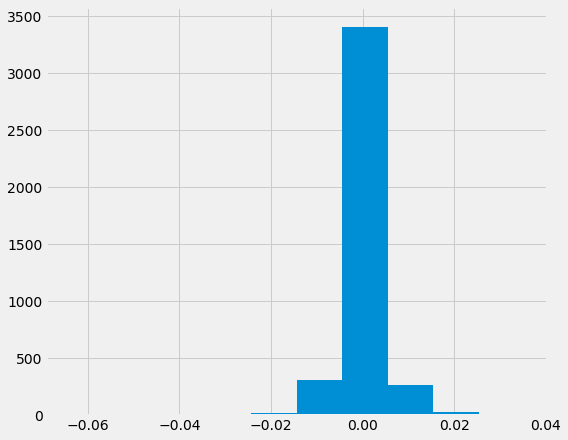

In [6]:
stock_df['percent change'].hist();

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.002619
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2020-06-16 12:30:00-04:00,263.269989,264.429993,263.269989,264.269989,264.269989,5622,-0.003798,0
2020-06-16 13:30:00-04:00,263.529999,264.290009,262.709991,263.429993,263.429993,11764,0.000379,0
2020-06-16 14:30:00-04:00,263.649994,263.850006,261.845001,262.959991,262.959991,11613,0.002617,0
2020-06-16 15:30:00-04:00,262.980011,263.859985,262.420013,263.799988,263.799988,14644,-0.003118,0
2020-06-16 16:00:00-04:00,263.740000,263.740000,263.740000,263.740000,263.740000,0,0.000000,0
2020-06-17 09:30:00-04:00,265.429993,265.459290,263.510010,263.890015,263.890015,22821,0.005802,0
2020-06-17 10:30:00-04:00,263.799988,265.410004,263.799988,264.790009,264.790009,10121,-0.003753,0
2020-06-17 11:30:00-04:00,265.049988,265.269989,264.579987,265.188110,265.188110,9198,-0.000521,0
2020-06-17 12:30:00-04:00,265.230011,266.200012,265.230011,265.989990,265.989990,14559,-0.002865,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

4051

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

4050

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(4050, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open               263.690002
High               264.242004
Low                263.480011
Close              264.242004
Adj Close          264.242004
Volume            1422.000000
percent change      -0.002093
decision             0.000000
Name: 2020-06-18 09:30:00-04:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2018-06-18 09:30:00-04:00,184.272507,185.220001,184.009995,185.199997,185.199997,0,-0.005033,0
2018-06-18 10:30:00-04:00,185.470200,186.350006,185.470200,186.070007,186.070007,10589,-0.003234,0
2018-06-18 11:30:00-04:00,186.119995,186.210007,185.830002,185.830002,185.830002,12388,0.001558,0
2018-06-18 12:30:00-04:00,185.869904,186.229996,185.779999,186.229996,186.229996,14237,-0.001937,0
2018-06-18 13:30:00-04:00,186.199997,186.429993,186.159500,186.429993,186.429993,9214,-0.001235,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    3961
1      89
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

89

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(178, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    89
0    89
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.6811145510835913

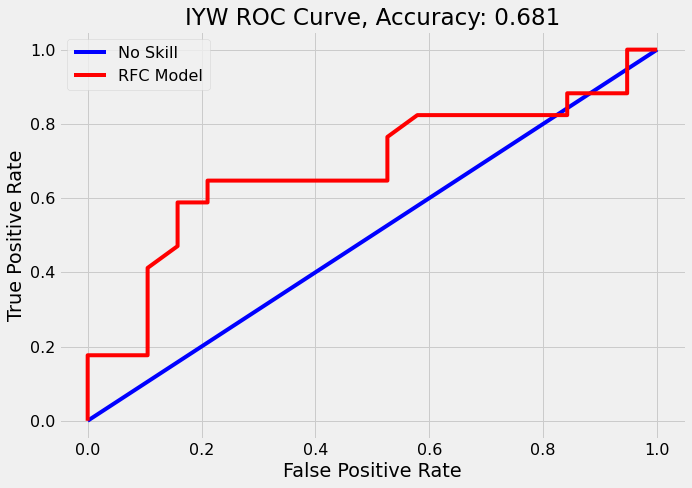

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


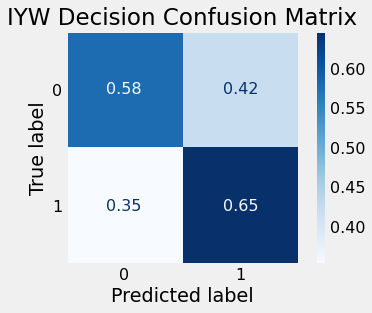

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

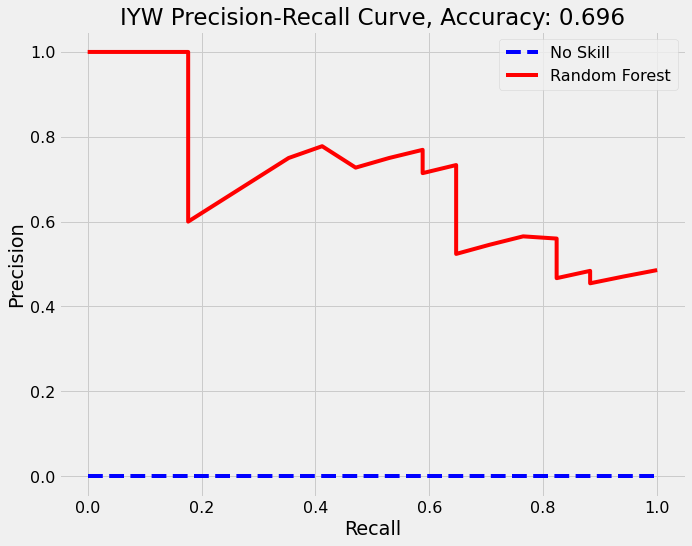

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
5,Volume,0.247985
0,Open,0.165613
3,Close,0.151098
4,Adj Close,0.147393
2,Low,0.144968
1,High,0.142943


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,197.009995,197.600006,197.000000,197.327896,197.327896,12160,-0.001614,0
1,189.322800,189.330002,189.074600,189.117096,189.117096,4770,0.001087,0
2,207.009995,207.140594,206.850006,206.850006,206.850006,2481,0.000773,0
3,205.699997,206.039993,205.699493,205.960007,205.960007,5086,-0.001264,0
4,236.500000,236.910000,236.500000,236.910000,236.910000,0,-0.001734,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open         264.390015
High         264.390015
Low          264.390015
Close        264.390015
Adj Close    264.390015
Volume         0.000000
Name: 2020-06-18 09:53:41-04:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold IYW on the 60m interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:    0.0s finished


# 